In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np


class PanopticSegmentationDataset(Dataset):
    def __init__(self, frames_path, labels_path, frames_id_list_path, transform=None):
        self.frames_path = frames_path
        self.labels_path = labels_path
        self.frames_id_list = self.read_frames_id_list(frames_id_list_path)
        self.transform = transform
    def __len__(self):
        
    def __getitem__(self, index):
            
        frames = load_frames_for_one_timestep(index)
        labels = load_labels_for_one_timestep(index)
        
        # apply transform
        if self.transform:
            frames = [self.transform(frame) for frame in frames]
            labels = [self.transform(label) for label in labels]
        
        return frames, labels
    
    def load_frames_for_one_timestep(self, index):
        # return a list of rgb input images: [FRONT, FRONT_LEFT, FRONT_RIGHT, SIDE_LEFT, SIDE_RIGHT]

            
    def load_labels_for_one_timestep(self, index):
        # return a list of rgb labeled images: [FRONT, FRONT_LEFT, FRONT_RIGHT, SIDE_LEFT, SIDE_RIGHT]
    
    def read_frames_id_list(self, txtFile):
        """
        input: txt file provided by Waymo

        output: a list of frames sorted by time_stamp, each frame: context_name, time_stamp
        """
        list_ = open(txtFile).read().split()
        frames_id_list = []
        pre_context_name = None
        context_name = None
        for line in list_:
            frames_line = line.split(',')
            context_name = frames_line[0]
            if(pre_context_name != context_name):
                frames_id_list.append(frames_line) 
            pre_context_name = context_name
        frames_id_list = sorted(frames_id_list, key=lambda frames_id_list: frames_id_list[1])
        return frames_id_list

In [22]:

        
train_frames_id_list = read_frames_id_list("./2d_pvps_training_frames.txt")
test_frames_id_list = read_frames_id_list("./2d_pvps_test_frames.txt")
validation_frames_id_list = read_frames_id_list("./2d_pvps_validation_frames.txt")

In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 32
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/training/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/training/camera_segmentation"
frames_id_list_path = "./2d_pvps_training_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [ ]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/testing/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/testing/camera_segmentation"
frames_id_list_path = "./2d_pvps_test_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, transform=test_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

In [ ]:
validation_transform = transforms.Compose([
    transforms.ToTensor()
])
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation/camera_segmentation"
frames_id_list_path = "./2d_pvps_validation_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, transform=validation_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

Loaded image (430782 bytes) for camera_image.key.camera_name=1 1553628864248893 camera_image.key.camera_name=1
Loaded bounding box for camera_box.key.camera_object_id='04ae1a3e-7b96-4cf8-bb73-6f2eb2bf91a4' camera_box.box=BoxAxisAligned2d(center=Vec2d(x=488.85066, y=780.01365), size=Vec2d(x=420.63893999999993, y=137.05503))


2023-04-14 15:33:27.950990: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 15:33:28.438417: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/foxy/lib/x86_64-linux-gnu:/opt/ros/foxy/lib:/usr/local/cuda/lib64
2023-04-14 15:33:28.438460: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skip

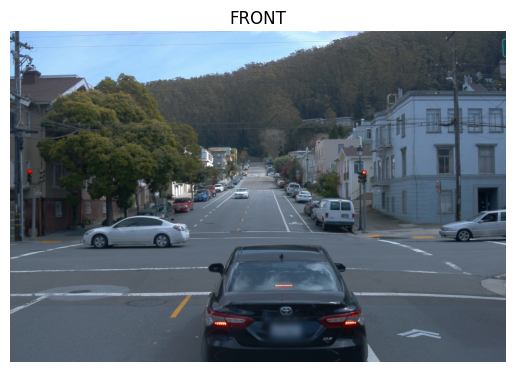

In [5]:
from waymo_open_dataset import dataset_pb2 as open_dataset
import matplotlib.pyplot as plt
import dask.dataframe as dd
import tensorflow as tf
from waymo_open_dataset import v2


camera_left_to_right_order = [open_dataset.CameraName.SIDE_LEFT, #4
                            open_dataset.CameraName.FRONT_LEFT, #2
                            open_dataset.CameraName.FRONT, #1
                            open_dataset.CameraName.FRONT_RIGHT, #3
                            open_dataset.CameraName.SIDE_RIGHT] #5

camera_name_list = {
   1 : "FRONT",
   2 : "FRONT_LEFT",
   3 : "FRONT_RIGHT",
   4 : "SIDE_LEFT",
   5 : "SIDE_RIGHT"
}
camera_name_num = 1

# Path to the directory with all components
dataset_dir = '/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation'

context_name = '17065833287841703_2980_000_3000_000'

def read(tag: str) -> dd.DataFrame:
  """Creates a Dask DataFrame for the component specified by its tag."""
  paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/{context_name}.parquet')
  return dd.read_parquet(paths)


camera_image_df = read('camera_image')
# Filter the images from camera=1
# NOTE: We could also use push down filters while reading the parquet files as well
# Details https://docs.dask.org/en/stable/generated/dask.dataframe.read_parquet.html#dask.dataframe.read_parquet
camera_image_df = camera_image_df[camera_image_df['key.camera_name'] == camera_name_num]

camera_box_df = read('camera_box')
# Inner join the camera_image table with the camera_box table.
df = camera_image_df.merge(
    camera_box_df,
    on=[
        'key.segment_context_name',
        'key.frame_timestamp_micros',
        'key.camera_name',
    ],
    how='inner',
)

# Create corresponding components from the raw
_, row = next(iter(df.iterrows()))

camera_image = v2.CameraImageComponent.from_dict(row)
camera_box = v2.CameraBoxComponent.from_dict(row)
print(
    f'Loaded image ({len(camera_image.image)} bytes) for'
    f' {camera_image.key.camera_name=} {camera_image.key.frame_timestamp_micros} {camera_image.key.camera_name=}'
)
print(
    'Loaded bounding box for'
    f' {camera_box.key.camera_object_id=} {camera_box.box=}'
)


plt.imshow(tf.image.decode_jpeg(camera_image.image))
plt.title(camera_name_list[camera_name_num])
plt.grid(False)
plt.axis('off')
plt.show()